In [18]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

import zipfile


# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, TimeSeriesSplit
from mlxtend.evaluate import GroupTimeSeriesSplit

from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, PredictionErrorDisplay
# Gradient Boosting Models
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Kaggle API (only import if not running in a Kaggle notebook)
iskaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")
if not iskaggle:
    import kaggle
    from kaggle.api.kaggle_api_extended import KaggleApi

In [19]:
class RohlikDataProcessor:
    def __init__(self, is_kaggle, path="rohlik-sales-forecasting-challenge-v2"):
        self.path = path
        self.column_transformer = None
        self.is_kaggle = is_kaggle

    def download_and_extract(self):
        if not self.is_kaggle and not Path(self.path).exists():
            zip_path = Path(f"{self.path}.zip")
            if not zip_path.exists():
                import kaggle
                kaggle.api.competition_download_cli('rohlik-sales-forecasting-challenge-v2')
            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(self.path)
            print("Dataset extracted successfully.")
        
        if self.is_kaggle:
            self.path = '/kaggle/input/rohlik-sales-forecasting-challenge-v2'  # Set Kaggle path explicitly

    def load_data(self, filename):
        return pd.read_csv(f"{self.path}/{filename}")
        
    def add_holidays_to_calender_df(self, calendar_raw_df):
        #taken from https://www.kaggle.com/code/macarrony00/not-a-winner-but-maybe-some-inspiration
        czech_holiday = [ 
            (['03/31/2024', '04/09/2023', '04/17/2022', '04/04/2021', '04/12/2020'], 'Easter Day'),#loss
            (['05/12/2024', '05/10/2020', '05/09/2021', '05/08/2022', '05/14/2023'], "Mother Day"), #loss
        ]
        brno_holiday = [
            (['03/31/2024', '04/09/2023', '04/17/2022', '04/04/2021', '04/12/2020'], 'Easter Day'),#loss
            (['05/12/2024', '05/10/2020', '05/09/2021', '05/08/2022', '05/14/2023'], "Mother Day"), #loss
        ]
        
        budapest_holidays = []
        munich_holidays = [
            (['03/30/2024', '04/08/2023', '04/16/2022', '04/03/2021'], 'Holy Saturday'),#loss
            (['05/12/2024', '05/14/2023', '05/08/2022', '05/09/2021'], 'Mother Day'),#loss
        ]
        
        frank_holidays = [
            (['03/30/2024', '04/08/2023', '04/16/2022', '04/03/2021'], 'Holy Saturday'),#loss
            (['05/12/2024', '05/14/2023', '05/08/2022', '05/09/2021'], 'Mother Day'),#loss
        ]
    
        def fill_loss_holidays(df_fill, warehouses, holidays):
            df = df_fill.copy()
            for item in holidays:
                dates, holiday_name = item
                generated_dates = [datetime.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d') for date in dates]
                for generated_date in generated_dates:
                    df.loc[(df['warehouse'].isin(warehouses)) & (df['date'] == generated_date), 'holiday'] = 1
                    df.loc[(df['warehouse'].isin(warehouses)) & (df['date'] == generated_date), 'holiday_name'] = holiday_name
            return df
        
        calendar_with_holidays_df = fill_loss_holidays(df_fill=calendar_raw_df, warehouses=['Prague_1', 'Prague_2', 'Prague_3'], holidays=czech_holiday)
        calendar_with_holidays_df = fill_loss_holidays(df_fill=calendar_with_holidays_df, warehouses=['Brno_1'], holidays=brno_holiday)
        calendar_with_holidays_df = fill_loss_holidays(df_fill=calendar_with_holidays_df, warehouses=['Munich_1'], holidays=munich_holidays)
        calendar_with_holidays_df = fill_loss_holidays(df_fill=calendar_with_holidays_df, warehouses=['Frankfurt_1'], holidays=frank_holidays)
        calendar_with_holidays_df = fill_loss_holidays(df_fill=calendar_with_holidays_df, warehouses=['Budapest_1'], holidays=budapest_holidays)
        return calendar_with_holidays_df
    

    def add_calender_and_inventory(self, df, calendar_with_holidays_df, inventory_raw_df):
        df_with_inventory = df.merge(inventory_raw_df[['unique_id', 'product_unique_id', 'name', 
                                      'L1_category_name_en', 'L2_category_name_en', 
                                      'L3_category_name_en', 'L4_category_name_en']], 
                        on='unique_id', how='left')
        
        df_with_inventory_and_calandar = df_with_inventory.merge(calendar_with_holidays_df[['date', 'warehouse', 'holiday', 'holiday_name', 
                                     'shops_closed', 'winter_school_holidays', 'school_holidays']], 
                        on=['date', 'warehouse'], how='left')
        return df_with_inventory_and_calandar


    def preprocess(self, train_df, test_df, target_col):

        train_df['sales'] = train_df['sales'].fillna(0)
        train_df['total_orders'] = train_df['total_orders'].fillna(0)
        train_df['sell_price_main'] = train_df['sell_price_main'].interpolate()

        train_df.drop(columns=['availability'], inplace=True)

        train_df['date'] = pd.to_datetime(train_df['date'])
        test_df['date'] = pd.to_datetime(test_df['date'])
        
        train_df['is_test'] = 0
        test_df['is_test'] = 1

        df = pd.concat([train_df, test_df], axis=0)
        
        
        discount_columns = ['type_0_discount', 'type_1_discount', 'type_2_discount', 
                            'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount']
        df['max_discount'] = df[discount_columns].max(axis=1)
        
        
        
        df = df.sort_values(by=['product_unique_id', 'warehouse', 'date'])
        
        periods = [3,7,10,14]
        for p in periods: 
            
            df['total_orders_mean_' + str(p)] = df.groupby(['product_unique_id', 'warehouse'])['total_orders'] \
            .rolling(window=p, min_periods=1) \
            .mean() \
            .reset_index(level=[0, 1], drop=True)
        
            df['total_orders_std_' + str(p)] = df.groupby(['product_unique_id', 'warehouse'])['total_orders'] \
            .rolling(window=p, min_periods=1) \
            .std() \
            .reset_index(level=[0, 1], drop=True)
        
            df['total_orders_max_' + str(p)] = df.groupby(['product_unique_id', 'warehouse'])['total_orders'] \
            .rolling(window=p, min_periods=1) \
            .max() \
            .reset_index(level=[0, 1], drop=True)
        
            df['total_orders_min_' + str(p)] = df.groupby(['product_unique_id', 'warehouse'])['total_orders'] \
            .rolling(window=p, min_periods=1) \
            .min() \
            .reset_index(level=[0, 1], drop=True)
        
        for lag in range(1, 15):  
            df[f'lag_{lag}'] = df.groupby(['product_unique_id', 'warehouse'])['sales'].shift(lag)
            df[f'lag_{lag}'] = df[f'lag_{lag}'].fillna(df.groupby(['product_unique_id', 'warehouse'])['sales'].transform("last"))
        
        
        categorical_columns = ['warehouse', 'name', 'L1_category_name_en', 'L2_category_name_en', 
                               'L3_category_name_en', 'L4_category_name_en', 'holiday_name']
        
            
        for col in categorical_columns:
            df[col] = df[col].astype('category')
            if col not in ['warehouse','L1_category_name_en']:
            # if col not in ['L1_category_name_en']:
                df[col] = df[col].cat.codes

        return df

    def add_date_columns(self, df):
        
        df["datetime"] = pd.to_datetime(df["date"])
        df["month"] = df["datetime"].dt.month
        df["day"] = df["datetime"].dt.day
        df["weekday"] = df["datetime"].dt.weekday
        df["quarter"] = df["datetime"].dt.quarter
        df["week_of_year"] = df["datetime"].dt.isocalendar().week
        df["day_of_year"] = df["datetime"].dt.dayofyear
        df["is_weekend"] = df["datetime"].dt.weekday.isin([5, 6]).astype(int)
        df["is_month_start"] = df["datetime"].dt.is_month_start.astype(int)
        df["is_month_end"] = df["datetime"].dt.is_month_end.astype(int)
        df['year_sin'] = np.sin(2 * np.pi * df['datetime'].dt.year)
        df['year_cos'] = np.cos(2 * np.pi * df['datetime'].dt.year)
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) 
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df_with_dates = df.copy()
        
        return df_with_dates

In [20]:
processor = RohlikDataProcessor(iskaggle, path="rohlik-sales-forecasting-challenge-v2")
processor.download_and_extract()

In [21]:
sales_train_raw_df = processor.load_data("sales_train.csv")
sales_test_raw_df = processor.load_data("sales_test.csv")
calendar_raw_df = processor.load_data("calendar.csv")
inventory_raw_df = processor.load_data("inventory.csv")
solution_raw_df = processor.load_data("solution.csv")
test_weights_raw_df = processor.load_data("test_weights.csv")

In [22]:
calendar_with_holidays_df = processor.add_holidays_to_calender_df(calendar_raw_df)

In [23]:
sales_train_df_with_inventory_and_calandar = processor.add_calender_and_inventory(sales_train_raw_df, calendar_with_holidays_df, inventory_raw_df)
sales_test_df_with_inventory_and_calandar = processor.add_calender_and_inventory(sales_test_raw_df, calendar_with_holidays_df, inventory_raw_df)

In [24]:
full_df = processor.preprocess(sales_train_df_with_inventory_and_calandar, sales_test_df_with_inventory_and_calandar, 'Sales')

In [25]:
full_with_dates_df = processor.add_date_columns(full_df)

In [26]:
weight_map = test_weights_raw_df.set_index('unique_id')['weight'].to_dict()

In [27]:
oofs = {}
scores = {}
test_preds = {}
COMPUTE_TEST = True

In [28]:
import datetime as dt
target = 'sales'
def cross_validate(estimator, features, plot_residuals=False, fit_params={}):
    kf = TimeSeriesSplit(n_splits=5, test_size=dt.timedelta(weeks=2).days)
    X = sales_train[features].copy()
    y = sales_train[target] ** (1/8)  # Apply 1/8th root transformation
       
    model = clone(estimator)
    val_preds = np.zeros(len(X))
    list_scores = []
    
    for fold, (trx_idx, val_idx) in enumerate(kf.split(X, y, groups=X['warehouse'])):
        X_train, y_train = X.iloc[trx_idx], y.iloc[trx_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
                
        model.fit(X_train.drop('unique_id', axis=1), y_train, **fit_params)
        y_pred_transformed = model.predict(X_val.drop('unique_id', axis=1))
        y_pred = (y_pred_transformed ** 8).clip(0, None)  # Reverse transformation (double root)
        val_preds[val_idx] += y_pred
        
        wmape = mean_absolute_error(
            (y_val ** 8), y_pred,  # Reverse transformation for MAE
            sample_weight=X_val["unique_id"].map(weight_map).values
        )
        list_scores.append(wmape)
        
        print(f' #{fold} - wmae: {wmape}')
        if plot_residuals:
            display = PredictionErrorDisplay.from_predictions((y_val ** 8), y_pred)
            plt.show()
    
    if isinstance(model, Pipeline):
        name_model = type(model[-1]).__name__
    else:
        name_model = type(model).__name__
        
    oofs[name_model] = val_preds
    scores[name_model] = list_scores
    print(f'wmae mean: {np.mean(list_scores)}')   
    
    if COMPUTE_TEST:
        print('Computing Test prediction....')
        model = clone(estimator)
        model.fit(X, y)
        
        test_pred_transformed = model.predict(sales_test[features])
        test_pred = (test_pred_transformed ** 8).clip(0, None)  # Reverse transformation for test
        test_preds[name_model] = test_pred
        print('Computing Test prediction - Ok')

# def cross_validate(estimator, features, plot_residuals=False, fit_params={}):
    # kf = GroupTimeSeriesSplit(n_splits=5,test_size=dt.timedelta(weeks=2).days)
    kf = TimeSeriesSplit(n_splits=5,test_size=dt.timedelta(weeks=2).days)
    X = sales_train[features].copy()
    y = sales_train[target]
       
    model = clone(estimator)
    val_preds = np.zeros(len(X))
    list_scores = []
    
    for fold, (trx_idx, val_idx) in enumerate(kf.split(X,y,groups=X['warehouse'])):        
        X_train, y_train = X.iloc[trx_idx], y.iloc[trx_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]      
                
        model.fit(X_train.drop('unique_id',axis=1),y_train, **fit_params)
        y_pred = model.predict(X_val.drop('unique_id',axis=1)).clip(0,None)
        val_preds[val_idx] += y_pred
        wmape = mean_absolute_error(y_val,y_pred,sample_weight=X_val["unique_id"].map(weight_map).values)
        list_scores.append(wmape)
        
        print(f' #{fold} - wmae: {wmape}')
        if plot_residuals:
            display = PredictionErrorDisplay.from_predictions(y_val,y_pred)            
            plt.show()
    if isinstance(model,Pipeline):
        name_model = type(model[-1]).__name__
    else:
        name_model = type(model).__name__                              
    

    oofs[name_model] = val_preds
    scores[name_model] = list_scores
    print(f'wmae mean: {np.mean(list_scores)}')   
    
    if COMPUTE_TEST:
        print('Computing Test prediction....')
        model = clone(estimator)
        model.fit(X,y)
        
        test_pred = model.predict(sales_test[features]).clip(0,None)
        test_preds[name_model] = test_pred
        print('Computing Test prediction - Ok')

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", 
            SimpleImputer(strategy="median")), 
            ("scaler", RobustScaler())]
)

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)


# For tree-based models that support early stopping
reg1 = Pipeline([("preprocessor", preprocessor), 
                 ("regressor", lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=10, num_leaves=31, subsample=0.8, colsample_bytree=0.8, verbosity=-1, device="gpu"))])

reg2 = Pipeline([("preprocessor", preprocessor), 
                 ("regressor", CatBoostRegressor(iterations=500, learning_rate=0.05, depth=8, l2_leaf_reg=3, loss_function="MAE",verbose=False, task_type="GPU", devices="0"))])

reg3 = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, subsample=0.8, colsample_bytree=0.8, objective="reg:squarederror", eval_metric="mae", tree_method="hist", device = "cuda"))
])

# Create stacking regressor with RidgeCV as the final estimator
ensemble = StackingRegressor(
    estimators=[ 
        ('lgbm', reg1), ('catboost', reg2), ('xgboost', reg3)
    ],
    final_estimator=RidgeCV(alphas=np.logspace(-3, 3, 10))  # RidgeCV automatically tunes alpha
)

features = ["unique_id",
    "warehouse", "total_orders", 
    "sell_price_main", "type_0_discount", "type_1_discount", "type_2_discount", 
    "type_3_discount", "type_4_discount", "type_5_discount", "type_6_discount", 
    "name", "L1_category_name_en", "L2_category_name_en", 
    "L3_category_name_en", "L4_category_name_en", "holiday", "holiday_name", 
    "shops_closed", "winter_school_holidays", "school_holidays", 
    "max_discount", "total_orders_mean_3", "total_orders_std_3", "total_orders_max_3", 
    "total_orders_min_3", "total_orders_mean_7", "total_orders_std_7", "total_orders_max_7", 
    "total_orders_min_7", "total_orders_mean_10", "total_orders_std_10", "total_orders_max_10", 
    "total_orders_min_10", "total_orders_mean_14", "total_orders_std_14", "total_orders_max_14", 
    "total_orders_min_14", "month", "day", "weekday", "quarter", "week_of_year", 
    "day_of_year", "is_weekend", "is_month_start", "is_month_end", "year_sin", 
    "year_cos", "month_sin", "month_cos", "day_sin", "day_cos",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", 
    "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "lag_13", "lag_14"
] 

In [30]:
full_with_dates_df = full_with_dates_df.sort_values(by=['warehouse', 'date'])
sales_train = full_with_dates_df[full_with_dates_df['is_test'] == 0]
sales_test = full_with_dates_df[full_with_dates_df['is_test'] == 1]

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #0 - wmae: 18.468153765028443


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


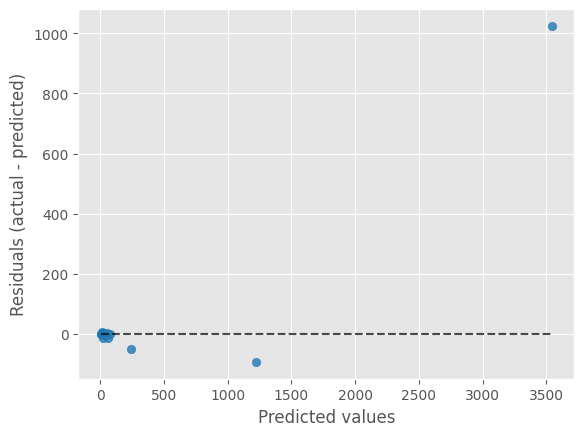

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #1 - wmae: 5.675898185167278


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


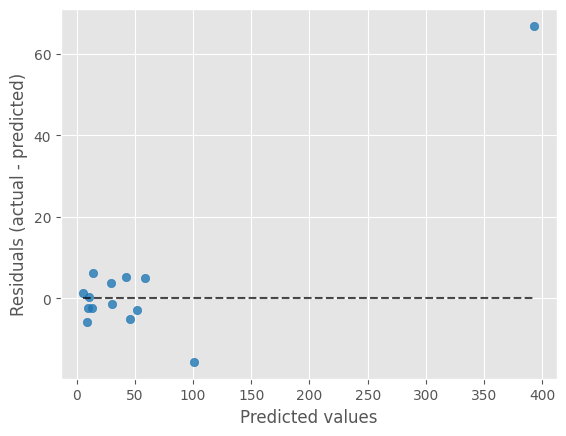

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #2 - wmae: 9.043344751061051


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


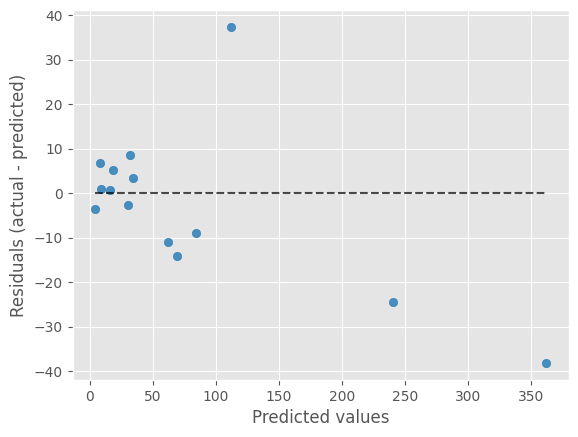

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #3 - wmae: 8.88927266532194


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


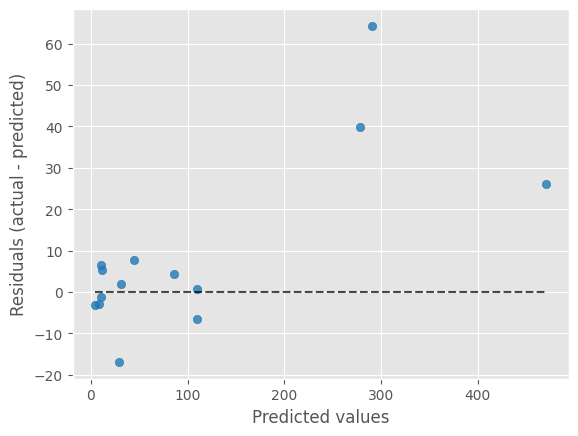

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #4 - wmae: 9.8656060061147


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


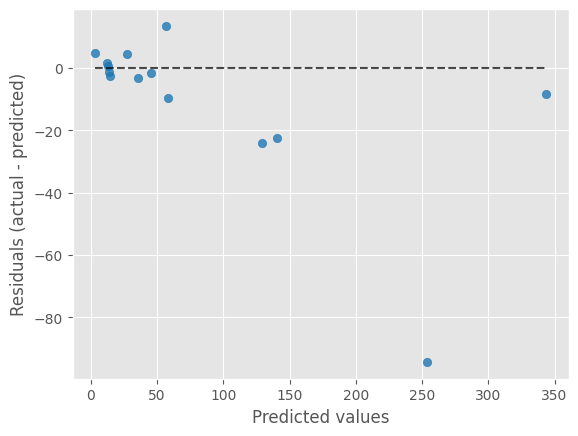

wmae mean: 10.388455074538683
Computing Test prediction....


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing Test prediction - Ok


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #0 - wmae: 19.873677697880634


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


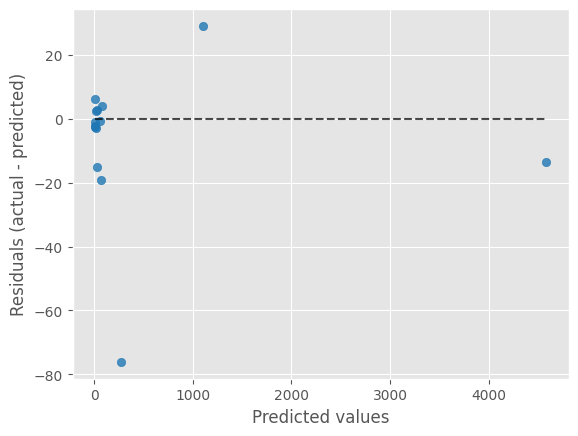

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #1 - wmae: 7.601759407047105


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


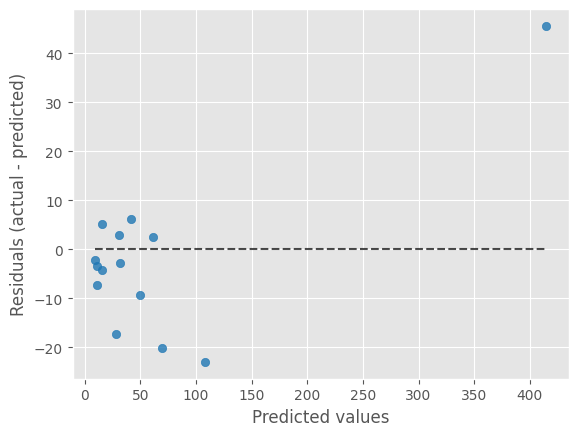

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #2 - wmae: 7.842101971450991


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


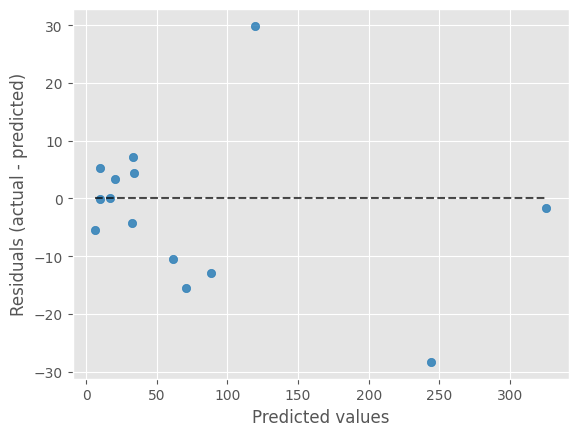

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #3 - wmae: 8.046139161934839


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


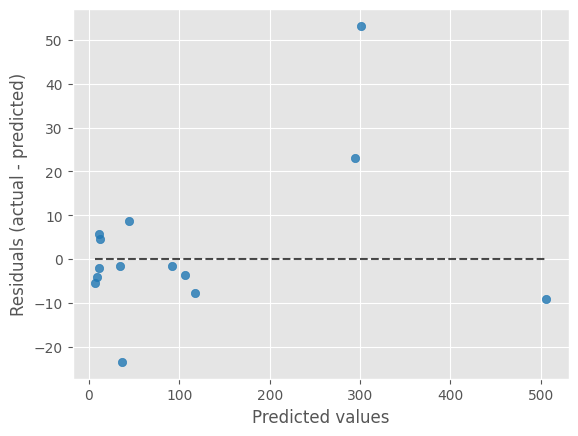

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 #4 - wmae: 21.82367618400877


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


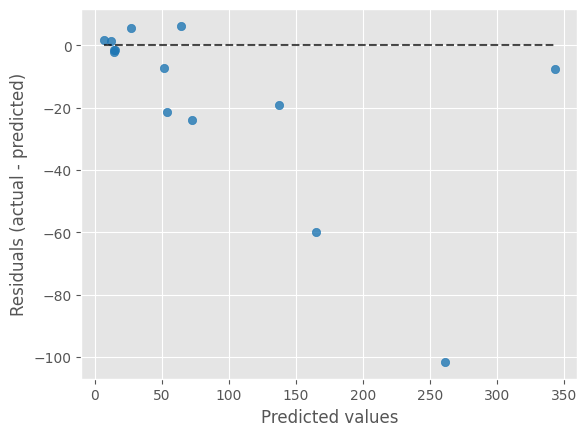

wmae mean: 13.037470884464469
Computing Test prediction....


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Computing Test prediction - Ok


In [31]:
cross_validate(reg1, features, plot_residuals=True, fit_params={})

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU


 #0 - wmae: 25.810871261042777


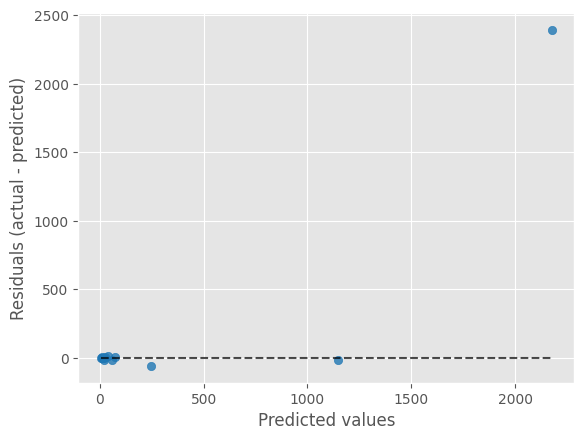

Default metric period is 5 because MAE is/are not implemented for GPU


 #1 - wmae: 7.2070400749638415


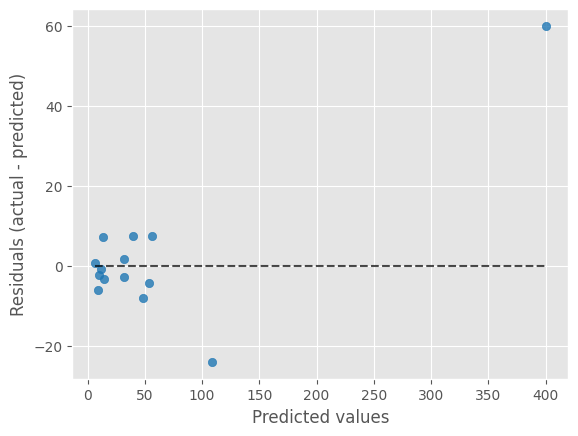

Default metric period is 5 because MAE is/are not implemented for GPU


 #2 - wmae: 8.722341572508137


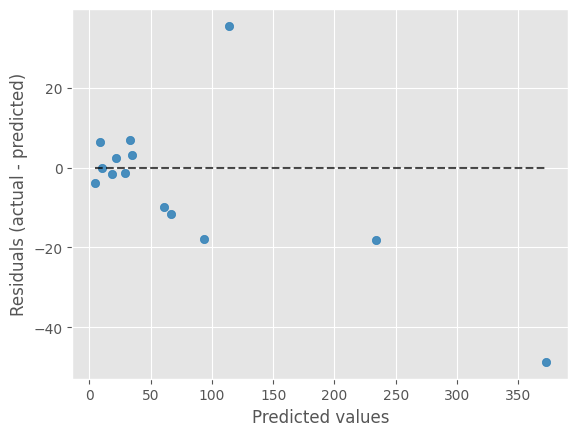

Default metric period is 5 because MAE is/are not implemented for GPU


 #3 - wmae: 9.56517790660603


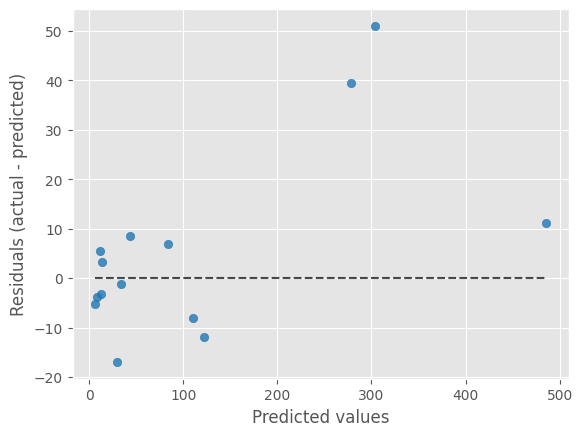

Default metric period is 5 because MAE is/are not implemented for GPU


 #4 - wmae: 22.172405145711135


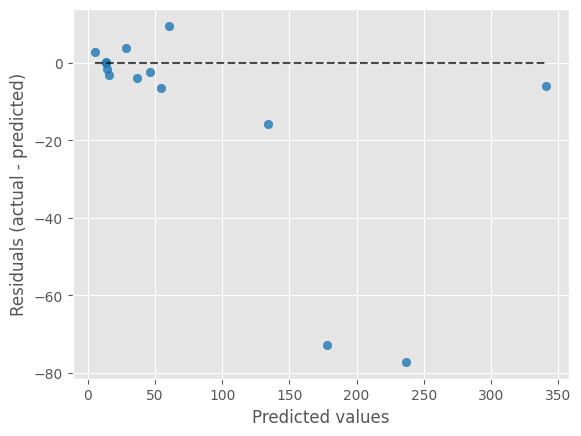

wmae mean: 14.695567192166385
Computing Test prediction....


Default metric period is 5 because MAE is/are not implemented for GPU


Computing Test prediction - Ok


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU


 #0 - wmae: 65.81149320959773


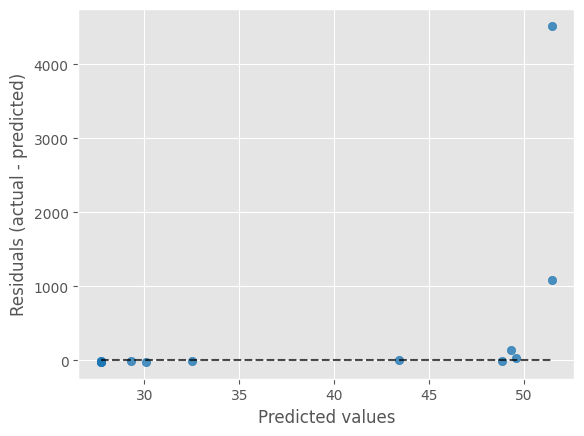

Default metric period is 5 because MAE is/are not implemented for GPU


 #1 - wmae: 20.995613470728305


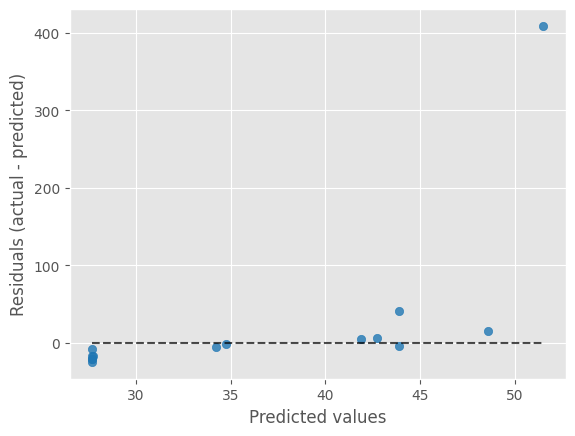

Default metric period is 5 because MAE is/are not implemented for GPU


 #2 - wmae: 32.154795384412786


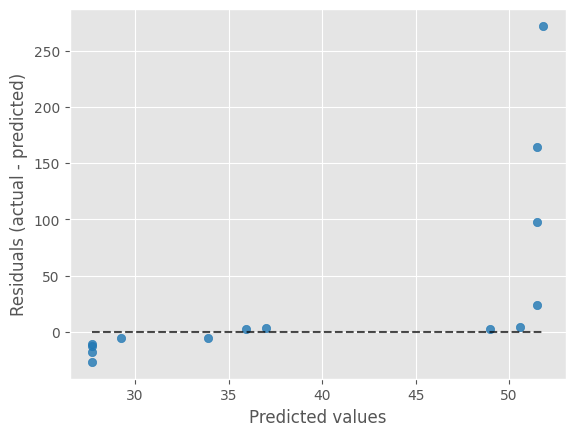

Default metric period is 5 because MAE is/are not implemented for GPU


 #3 - wmae: 47.249626623701445


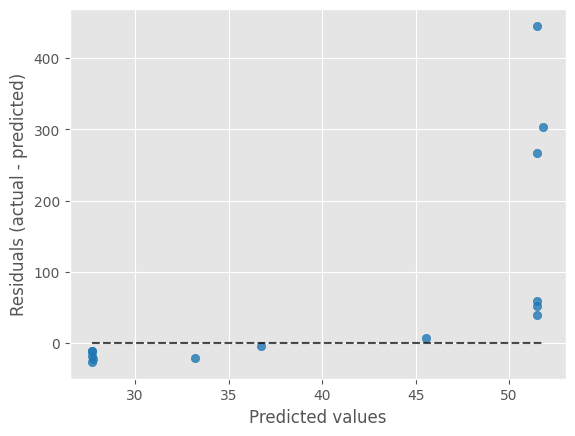

Default metric period is 5 because MAE is/are not implemented for GPU


 #4 - wmae: 32.101211698170616


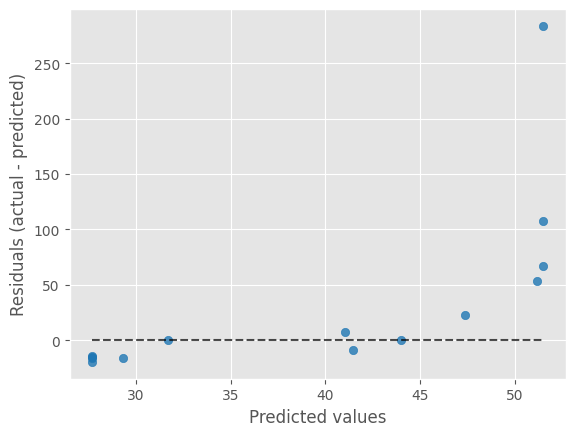

wmae mean: 39.66254807732217
Computing Test prediction....


Default metric period is 5 because MAE is/are not implemented for GPU


Computing Test prediction - Ok


In [32]:
cross_validate(reg2, features, plot_residuals=True, fit_params={})

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


 #0 - wmae: 15.292724764409055


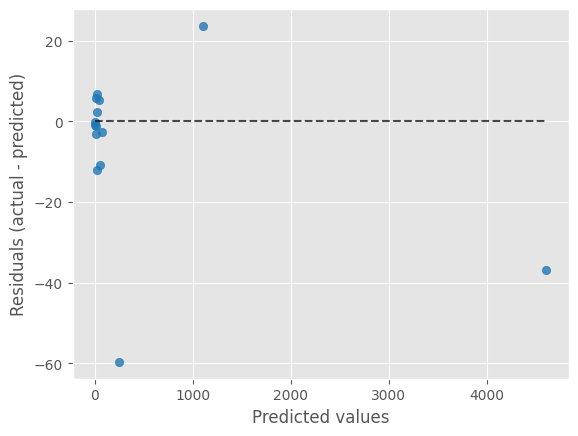

 #1 - wmae: 6.150513119971664


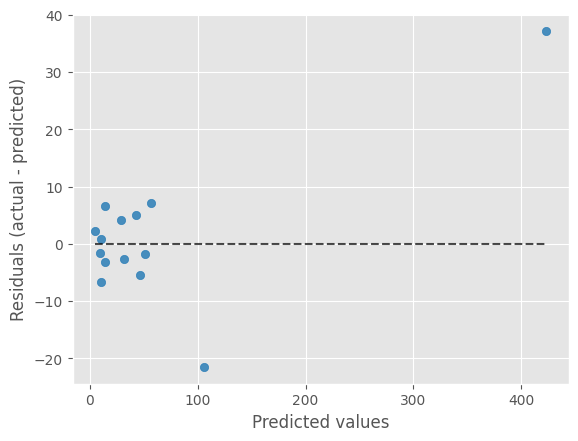

 #2 - wmae: 8.67929971032015


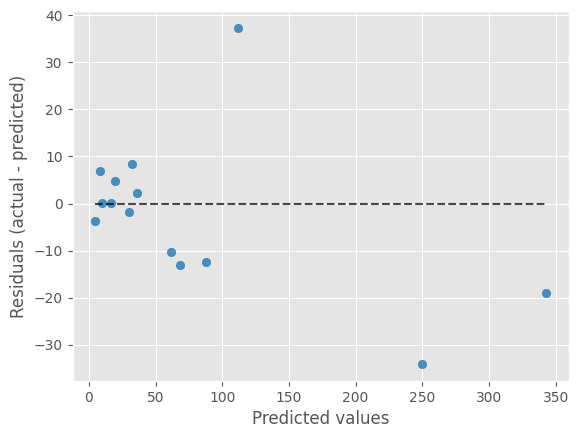

 #3 - wmae: 9.068298339601318


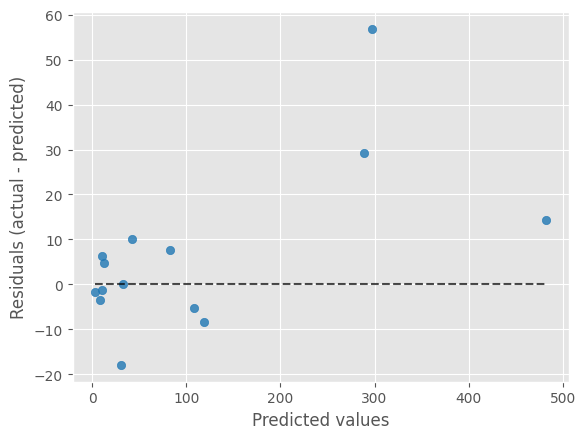

 #4 - wmae: 17.05247634827803


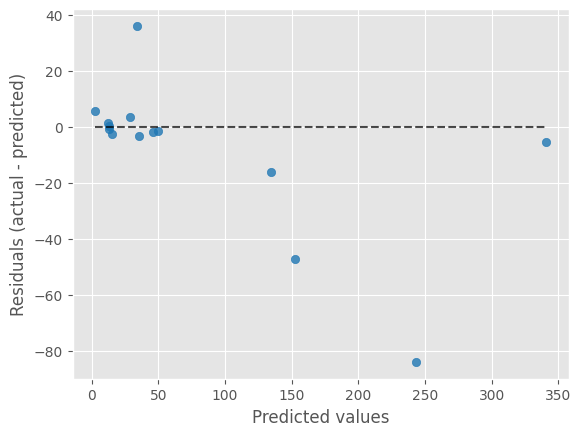

wmae mean: 11.248662456516044
Computing Test prediction....
Computing Test prediction - Ok


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


 #0 - wmae: 17.836264372270662


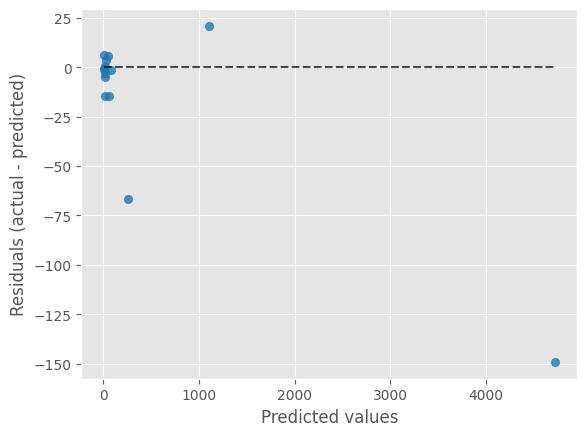

 #1 - wmae: 5.509010796061372


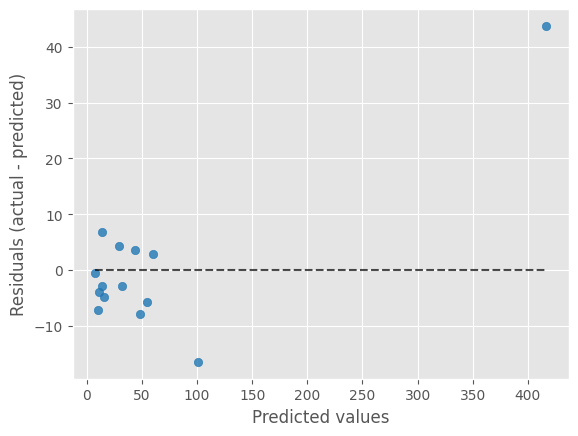

 #2 - wmae: 8.053248717185873


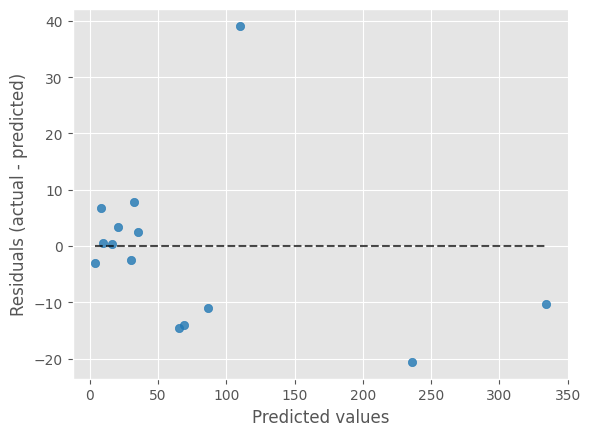

 #3 - wmae: 8.734213577930431


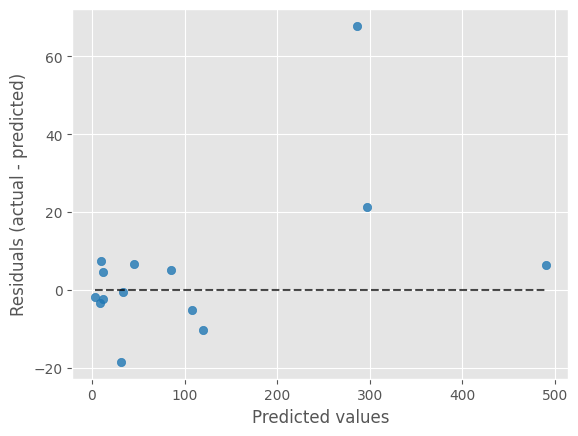

 #4 - wmae: 19.46927322122429


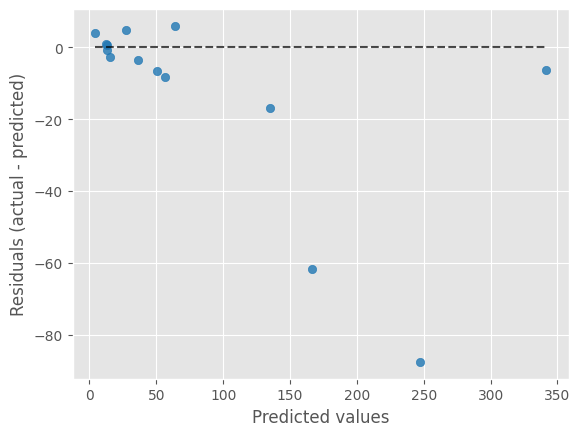

wmae mean: 11.920402136934525
Computing Test prediction....
Computing Test prediction - Ok


In [33]:
cross_validate(reg3, features, plot_residuals=True, fit_params={})

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

 #0 - wmae: 26.59731027878018


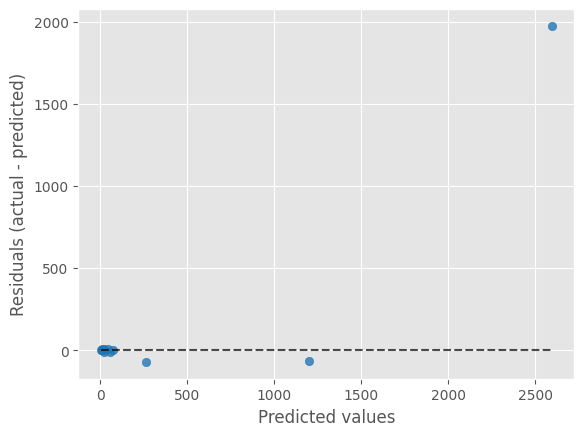

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

 #1 - wmae: 6.57748467405276


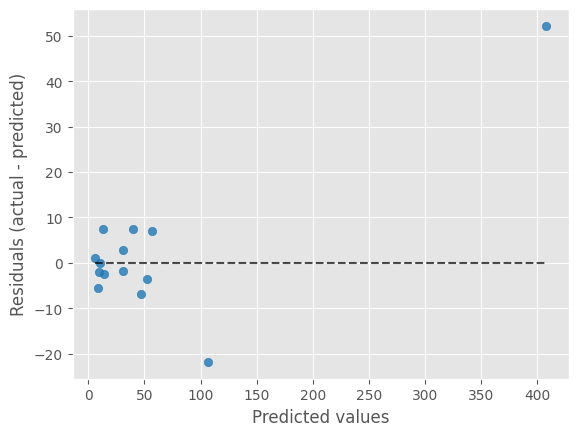

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

 #2 - wmae: 9.338690229950332


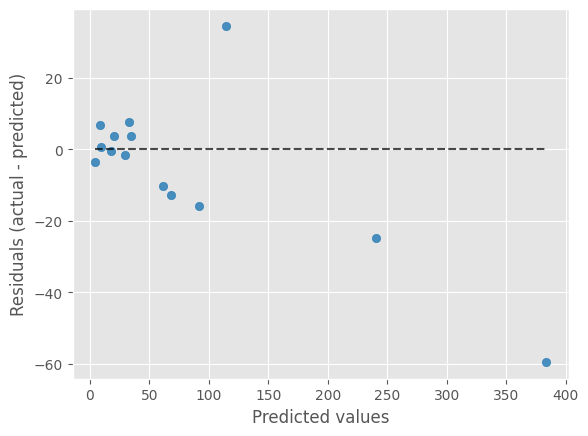

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

 #3 - wmae: 8.76745676984343


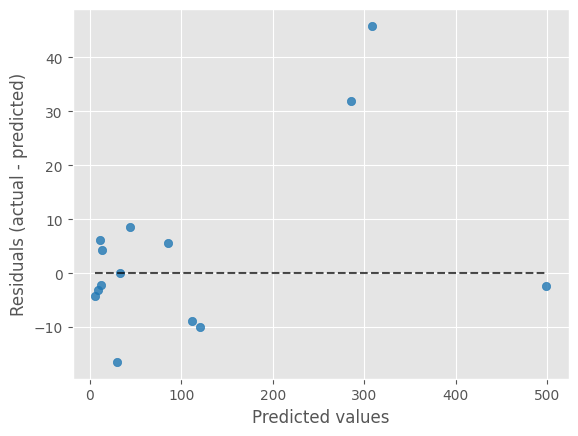

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

 #4 - wmae: 17.656794169958204


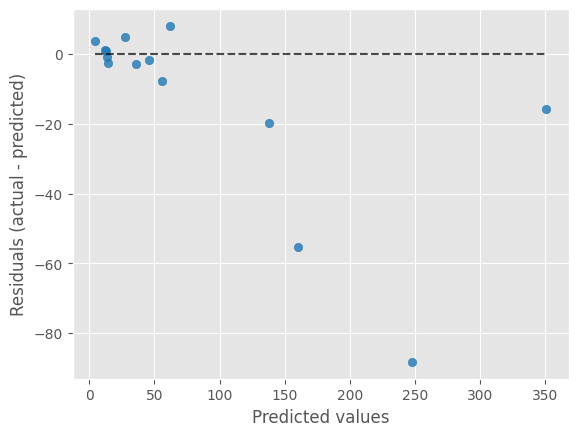

wmae mean: 13.787547224516981
Computing Test prediction....


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

Computing Test prediction - Ok


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\model_selection\_split.py:1242: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

 #0 - wmae: 17.05214325420335


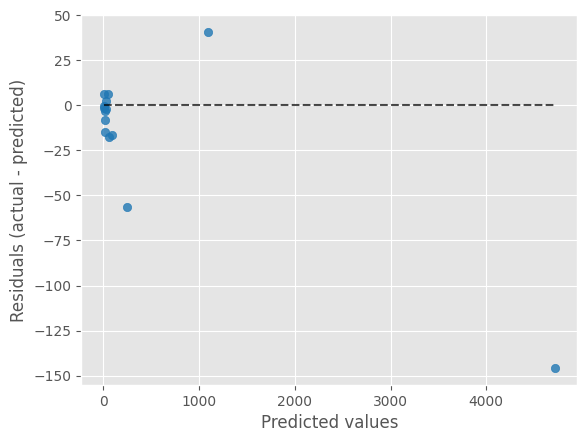

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

 #1 - wmae: 4.544584728103963


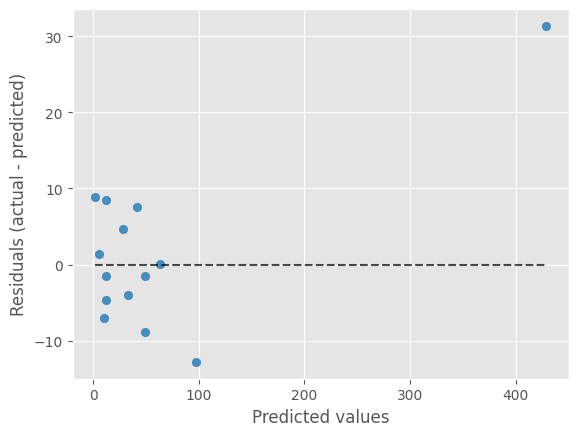

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

 #2 - wmae: 9.761074013093085


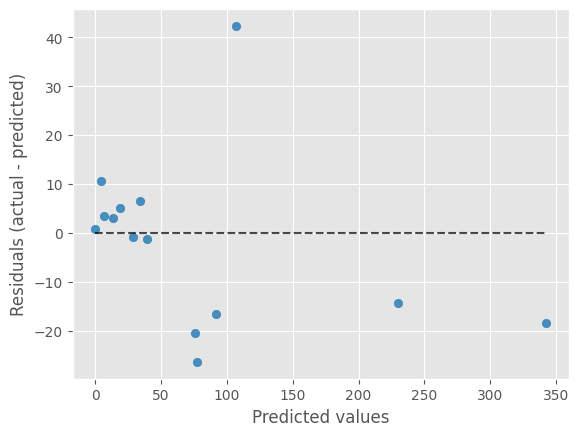

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

 #3 - wmae: 10.080136724852977


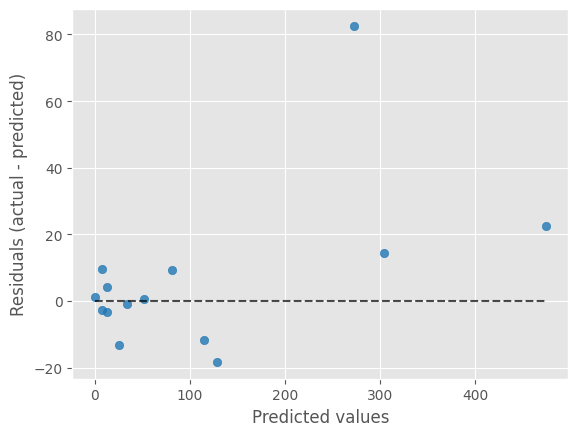

c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

 #4 - wmae: 24.73508668021203


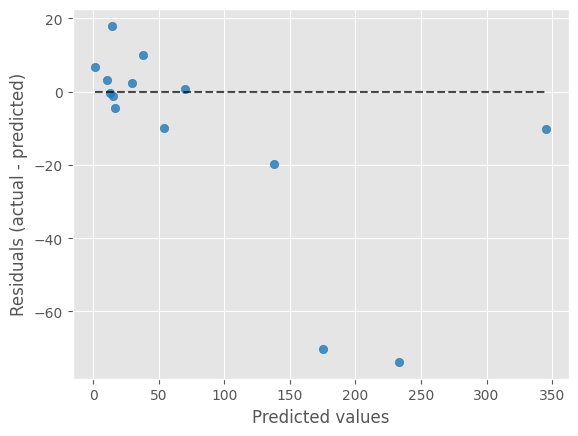

wmae mean: 13.23460508009308
Computing Test prediction....


c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Default metric period is 5 because MAE is/are not implemented for GPU
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lawrence\Documents\PYTHON\1_kaggle_competitions\rohlik_feb_25\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensur

Computing Test prediction - Ok


In [34]:
cross_validate(ensemble, features, plot_residuals=True, fit_params={})

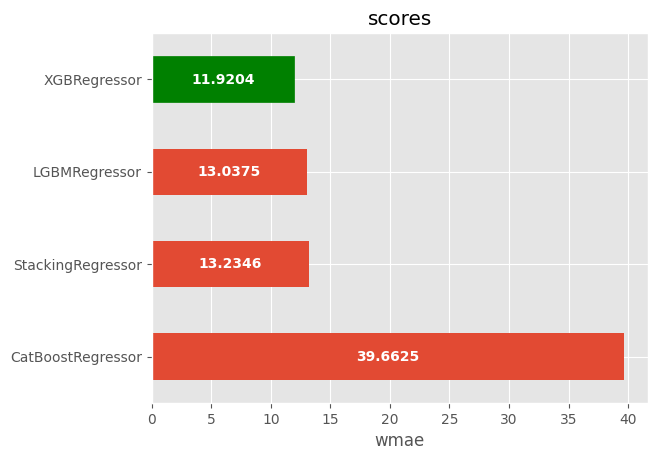

In [35]:
df_score = pd.DataFrame().from_dict(scores)
ax = df_score.mean().sort_values(ascending=False).plot(kind='barh')
bars = ax.patches
bars[-1].set_color('green')
ax.bar_label(ax.containers[0],label_type='center',color='white',fontweight='bold')
plt.title('scores')
ax.set_xlabel('wmae')
plt.show()

In [38]:
if COMPUTE_TEST:
    solution_raw_df['sales_hat'] = test_preds['StackingRegressor'].clip(0,None)
    solution_raw_df.to_csv('submission.csv',index=False)